# | Modeling | - Experimentation of Monte Carlo simulations to generate Confidence Intervals
## Generating Confidence Intervals for Tree-based model's forecasts.

**Objetivo**: The primary objective of this notebook is to perform experimentation with the tree-based models for multi-step ahead forecasting.

**Conclusions**:


## 1.0 Imports

In [1]:
import sys
import os

sys.path.insert(0,'../..')

import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
import logging
from joblib import load, dump
from scipy.stats import uniform, randint, norm
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.ensemble import ExtraTreesRegressor

from concurrent.futures import ThreadPoolExecutor, as_completed

### 2.0 Definindo Parâmetros

In [2]:
def create_date_features(df: pd.DataFrame, date_column: str = "DATE") -> pd.DataFrame:
    """Creates date-based features from the specified date column."""

    df['DAY_OF_MONTH'] = df[date_column].dt.day
    df['MONTH'] = df[date_column].dt.month
    df['QUARTER'] = df[date_column].dt.quarter
    df['DAY_OF_WEEK'] = df[date_column].dt.weekday
    df['WEEK_OF_MONTH'] = (df['DAY_OF_MONTH'] - 1) // 7 + 1
    df['YEAR'] = df[date_column].dt.year

    return df

In [3]:
raw_df = pd.read_csv(os.path.join('../../data/raw/raw_df.csv'), parse_dates=["DATE"])


In [4]:
raw_df

,DATE,TICKER,CLOSE
0,2019-06-19,BOVA11.SA,96.629997
1,2019-06-21,BOVA11.SA,98.220001
2,2019-06-24,BOVA11.SA,98.309998
3,2019-06-25,BOVA11.SA,96.360001
4,2019-06-26,BOVA11.SA,96.849998
...,...,...,...
9939,2024-06-13,BRSR6.SA,10.808521
9940,2024-06-14,BRSR6.SA,10.877743
9941,2024-06-17,BRSR6.SA,10.820000
9942,2024-06-18,BRSR6.SA,10.900000


In [5]:
stock_df_feat_all = pd.read_csv(os.path.join('../../data/processed/processed_df.csv'), parse_dates=["DATE"])
# stock_df_feat_all.drop(columns=['CLOSE_LAG_1', 'CLOSE_LAG_2', 'CLOSE_MA_3'], inplace=True)

In [6]:
stock_df_feat_all

,DATE,TICKER,CLOSE,DAY_OF_MONTH,DAY_OF_WEEK,WEEK_OF_MONTH,MONTH,QUARTER,YEAR,CLOSE_LAG_1,CLOSE_LAG_2,CLOSE_MA_3
0,2019-06-25,BOVA11.SA,96.360,25,1,4,6,2,2019,98.310,98.220,97.720
1,2019-06-26,BOVA11.SA,96.850,26,2,4,6,2,2019,96.360,98.310,97.630
2,2019-06-27,BOVA11.SA,97.070,27,3,4,6,2,2019,96.850,96.360,97.173
3,2019-06-28,BOVA11.SA,97.110,28,4,4,6,2,2019,97.070,96.850,96.760
4,2019-07-01,BOVA11.SA,97.450,1,0,1,7,3,2019,97.110,97.070,97.010
...,...,...,...,...,...,...,...,...,...,...,...,...
9915,2024-06-13,BRSR6.SA,10.809,13,3,2,6,2,2024,10.848,10.977,10.871
9916,2024-06-14,BRSR6.SA,10.878,14,4,2,6,2,2024,10.809,10.848,10.878
9917,2024-06-17,BRSR6.SA,10.820,17,0,3,6,2,2024,10.878,10.809,10.845
9918,2024-06-18,BRSR6.SA,10.900,18,1,3,6,2,2024,10.820,10.878,10.836


In [4]:

df = stock_df_feat_all.pivot_table(values="CLOSE",index=["DATE"], columns=["TICKER"]).reset_index()
df = create_date_features(df)

TARGET_COL = 'BRSR6.SA'
EXOG_COLS = ['BBSE3.SA', 'BCFF11.SA', 'BOVA11.SA', 'CSMG3.SA', 'EGIE3.SA', 'PETR4.SA', 'TAEE4.SA']
FORECAST_HORIZON = 5

In [5]:
df = df.set_index("DATE")
df.tail()

TICKER,BBSE3.SA,BCFF11.SA,BOVA11.SA,BRSR6.SA,CSMG3.SA,EGIE3.SA,PETR4.SA,TAEE4.SA,DAY_OF_MONTH,MONTH,QUARTER,DAY_OF_WEEK,WEEK_OF_MONTH,YEAR
DATE,,,,,,,,,,,,,,
2024-06-10,32.62,8.49,117.35,10.91,19.70,43.48,36.463,11.22,10,6,2,0,2,2024
2024-06-11,32.78,8.48,118.00,11.10,19.45,43.59,36.618,11.32,11,6,2,1,2,2024
2024-06-12,32.47,8.51,116.46,10.97,19.31,43.47,35.820,11.20,12,6,2,2,2,2024
2024-06-13,32.51,8.29,116.18,10.93,19.57,43.61,35.460,11.16,13,6,2,3,2,2024
2024-06-14,32.59,8.30,116.63,10.98,19.68,43.84,35.350,11.20,14,6,2,4,2,2024


In [6]:
df = df[df.index >= pd.to_datetime('2022-01-01')]

In [7]:
print(f"Shape Original: {df.shape}")
dtrain = df.iloc[:len(df) - FORECAST_HORIZON, :]
dtest = df.iloc[len(df) - FORECAST_HORIZON:, :]

print(f"Shape do Treino: {dtrain.shape}")
print(f"Shape do Teste: {dtest.shape}")

X_train, y_train = dtrain.drop(columns=[TARGET_COL]), dtrain[TARGET_COL]
X_test, y_test = dtest.drop(columns=[TARGET_COL]), dtest[TARGET_COL]

Shape Original: (612, 14)
Shape do Treino: (607, 14)
Shape do Teste: (5, 14)


In [8]:
dtrain.tail(1)

TICKER,BBSE3.SA,BCFF11.SA,BOVA11.SA,BRSR6.SA,CSMG3.SA,EGIE3.SA,PETR4.SA,TAEE4.SA,DAY_OF_MONTH,MONTH,QUARTER,DAY_OF_WEEK,WEEK_OF_MONTH,YEAR
DATE,,,,,,,,,,,,,,
2024-06-07,32.69,8.61,117.13,10.98,19.72,43.48,35.918,11.29,7,6,2,4,1,2024


In [9]:
dtest.head(1)

TICKER,BBSE3.SA,BCFF11.SA,BOVA11.SA,BRSR6.SA,CSMG3.SA,EGIE3.SA,PETR4.SA,TAEE4.SA,DAY_OF_MONTH,MONTH,QUARTER,DAY_OF_WEEK,WEEK_OF_MONTH,YEAR
DATE,,,,,,,,,,,,,,
2024-06-10,32.62,8.49,117.35,10.91,19.7,43.48,36.463,11.22,10,6,2,0,2,2024


In [10]:
## Training the Model
model = ExtraTreesRegressor(verbose=0, n_jobs=1).fit(X_train, y_train)

In [11]:
# Monte Carlo
num_simulations = 10**5
num_threads = 8

# 1. Fit Probability Distributions to Historical Data
distributions = {}  # Dictionary to store fitted distributions for each feature

for col in EXOG_COLS:
    # Analyze the distribution of each feature in your historical data and fit a suitable distribution
    # Example: Assuming a normal distribution for GDP
    distributions[col] = norm(loc=X_train[col].mean(), scale=X_train[col].std())

# 2. Monte Carlo Simulation

results = X_test.copy()
def run_simulation(sim):
    
    simulated_X = X_test.copy()

    for col in EXOG_COLS:
        # Generate random samples for each feature based on the fitted distribution
        random_samples = distributions[col].rvs(size=FORECAST_HORIZON)
        simulated_X[col] = random_samples  # Store the samples

    # Make predictions using the simulated features
    simulated_forecast = model.predict(simulated_X)
    return simulated_forecast

In [12]:
results = X_test.copy()
simulated_forecasts = []
with ThreadPoolExecutor(max_workers=num_threads) as executor:
    futures = [executor.submit(run_simulation, sim) for sim in range(num_simulations)]

    for i, future in enumerate(as_completed(futures)):
        sim_result = future.result()
        #results[f"FORECAST_{i}"] = sim_result
        simulated_forecasts.append(pd.Series(sim_result, name=f"FORECAST_{i}", index=results.index))

In [13]:
simulated_forecasts_df = pd.concat(simulated_forecasts, axis=1)
results = pd.concat([results, simulated_forecasts_df], axis=1)

In [14]:
# 3. Calculate Confidence Intervals
results['lower'] = results.iloc[:, -num_simulations:].apply(lambda x: np.percentile(x, 5), axis=1)
results['upper'] = results.iloc[:, -num_simulations:].apply(lambda x: np.percentile(x, 95), axis=1)
results['actual_values'] = y_test
results.reset_index(inplace=True)

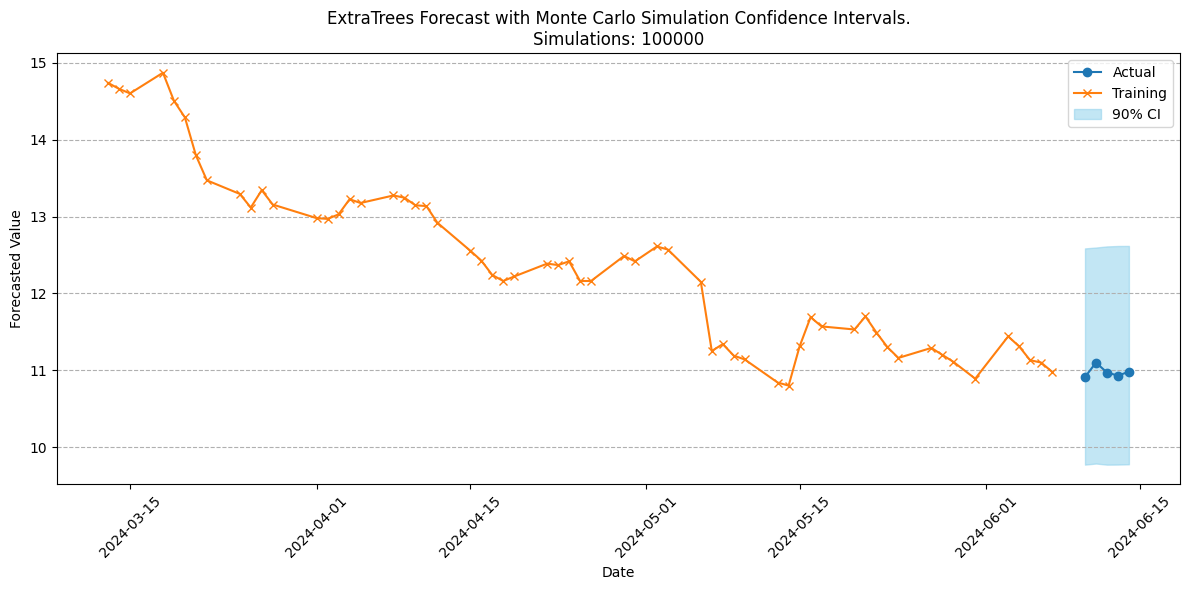

In [15]:
plt.figure(figsize=(12, 6))

# Plot actual values (if available)
if 'actual_values' in results.columns:
    plt.plot(results['DATE'], results['actual_values'], label='Actual', marker='o', linestyle='-')

# Plot point forecastss
plt.plot(dtrain.iloc[-60:, :].index, dtrain.iloc[-60:, :]['BRSR6.SA'], label='Training', marker='x', linestyle='-')

# Fill the confidence interval area
plt.fill_between(results['DATE'], results['lower'], results['upper'], color='skyblue', alpha=0.5, label='90% CI')

# Customize plot
plt.xlabel('Date')
plt.ylabel('Forecasted Value')
plt.title(f'ExtraTrees Forecast with Monte Carlo Simulation Confidence Intervals.\nSimulations: {num_simulations}')
plt.legend()
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--')
plt.tight_layout()
plt.show()


In [29]:
results.to_csv("./monte_carlo_brsr6.csv", index=False)

In [22]:
bin_size = 0.5

# Create empty dictionary
probabilities_by_day = {}
last_price = y_train.iloc[-1]

# Iterate through unique dates in results
for date in [results['DATE'].unique()[0]]:
    lower_bounds = results[results['DATE'] == date]['lower']
    upper_bounds = results[results['DATE'] == date]['upper']
    predicted_values = results[results['DATE'] == date].iloc[:, -num_simulations-3:-3].T.values
    #predicted_values = predicted_values - last_price
    
    # Find min and max values of confidence intervals
    min_value = np.floor(lower_bounds.min() / bin_size) * bin_size
    max_value = np.ceil(upper_bounds.max() / bin_size) * bin_size

    bins = np.arange(min_value, max_value + bin_size, bin_size)
    print(f'Price Bins: {bins}')
    bin_labels = [f"{bin}-{bin + bin_size}" for bin in bins[:-1]]  # Create labels for the bins

    probabilities = []
    for i in range(len(bins) - 1):
        lower_bound = bins[i]
        upper_bound = bins[i + 1]
        probability = ((predicted_values >= lower_bound) & (predicted_values < upper_bound)).mean()
        probabilities.append(probability)

    prob_df = pd.DataFrame({'Bin': bin_labels, 'Probability': probabilities})
    probabilities_by_day[date] = prob_df

# Print results
for date, prob_df in probabilities_by_day.items():
    print(f"\nPrediction results for {date}:")
    for index, row in prob_df.iterrows():
        bin_label = row['Bin']
        probability = round(row['Probability'] * 100, 2)
        print(f"- Proba of forecasted value be between [{bin_label}): {probability}%")
    print(f"Sum of probabilities: {prob_df['Probability'].sum()}")

Price Bins: [ 9.5 10.  10.5 11.  11.5 12.  12.5 13. ]

Prediction results for 2024-06-10 00:00:00:
- Proba of forecasted value be between [9.5-10.0): 4.97%
- Proba of forecasted value be between [10.0-10.5): 11.15%
- Proba of forecasted value be between [10.5-11.0): 17.72%
- Proba of forecasted value be between [11.0-11.5): 22.78%
- Proba of forecasted value be between [11.5-12.0): 19.37%
- Proba of forecasted value be between [12.0-12.5): 14.57%
- Proba of forecasted value be between [12.5-13.0): 6.12%
Sum of probabilities: 0.9667899999999999


In [23]:
last_price = y_train.iloc[-1]
bins=np.arange(predicted_values.min(), predicted_values.max() + bin_size, bin_size)

lower_bound = np.percentile(predicted_values, 10)
upper_bound = np.percentile(predicted_values, 90)

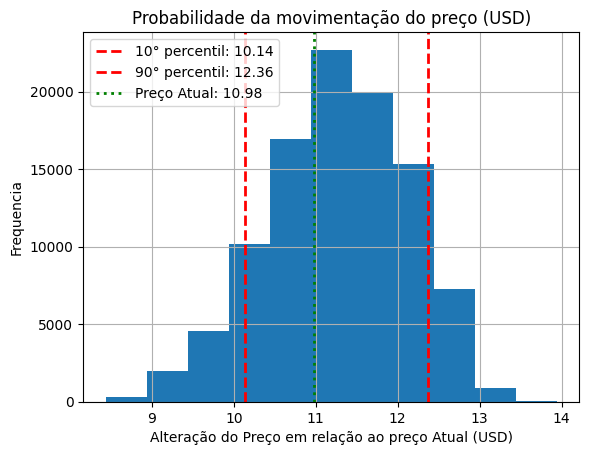

In [24]:
bin_size=0.5
plt.hist(
    x=predicted_values,
    bins=bins
)

# Add the vertical red lines at the 10th and 90th percentiles
plt.axvline(lower_bound, color='red', linestyle='dashed', linewidth=2, label=f'10° percentil: {lower_bound:.2f}')
plt.axvline(upper_bound, color='red', linestyle='dashed', linewidth=2, label=f'90° percentil: {upper_bound:.2f}')
plt.axvline(last_price, color='green', linestyle='dotted', linewidth=2, label=f'Preço Atual: {last_price:.2f}')

plt.title("Probabilidade da movimentação do preço (USD)")
plt.xlabel("Alteração do Preço em relação ao preço Atual (USD)")
plt.ylabel("Frequencia")
plt.grid()
plt.legend()
plt.show()

In [25]:
last_price = y_train.iloc[-1]
predicted_values = predicted_values - last_price
bins=np.arange(predicted_values.min(), predicted_values.max() + bin_size, bin_size)

lower_bound = np.percentile(predicted_values, 10)
upper_bound = np.percentile(predicted_values, 90)

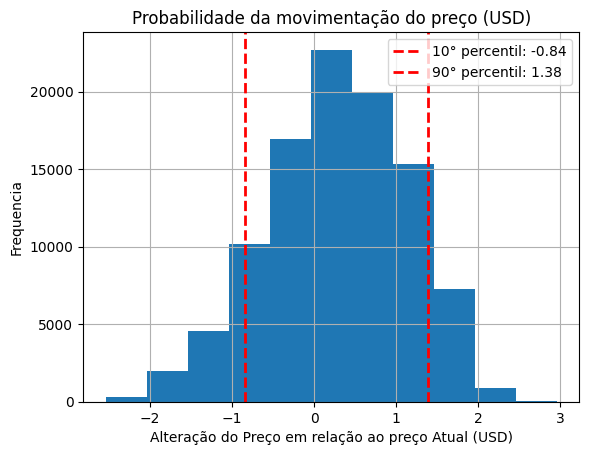

In [26]:
bin_size=0.5
plt.hist(
    x=predicted_values,
    bins=bins
)

# Add the vertical red lines at the 10th and 90th percentiles
plt.axvline(lower_bound, color='red', linestyle='dashed', linewidth=2, label=f'10° percentil: {lower_bound:.2f}')
plt.axvline(upper_bound, color='red', linestyle='dashed', linewidth=2, label=f'90° percentil: {upper_bound:.2f}')

plt.title("Probabilidade da movimentação do preço (USD)")
plt.xlabel("Alteração do Preço em relação ao preço Atual (USD)")
plt.ylabel("Frequencia")
plt.grid()
plt.legend()
plt.show()